In [1]:
# boiler plate
from collections import Counter
import pickle
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


import ipdb
import mytf.utils as mu

tf.enable_eager_execution()

print(tf.executing_eagerly())



True


In [2]:
with open('models/2019-05-19T001217-UTC-outdata--SUBSET.pkl', 'rb') as fd:
    minidata = pickle.load(fd)
    

In [3]:
reload(mu)
#Hand-tuned ... 
# Previous weights:
# class_weights = {0: 1.0, 1: 1.3, 2: 1.0, 3: 0.55}

# New weights:
class_weights = {0: 1.0, 1: 1.3, 2: 1.0, 3: 0.75}
training_indices = np.arange(0, minidata['x_train'].shape[0], 1)[:47000]
print('training indices...', training_indices.shape)

dataset_batches = mu.build_dataset_weighty_v3(minidata, training_indices, class_weights,
        batch_size=1000)


training indices... (47000,)
Start build v3: .. doesnt add up to 1.0
num slices 47
size_remainder,  0
Counter({3: 408, 2: 249, 0: 205, 1: 138})
weights_per_class,  tf.Tensor([0.00487805 0.00942029 0.00401606 0.00183824], shape=(4,), dtype=float32)
939.3999999999974
Counter({3: 418, 2: 217, 0: 211, 1: 154})
weights_per_class,  tf.Tensor([0.00473934 0.00844156 0.00460829 0.00179426], shape=(4,), dtype=float32)
941.6999999999975
Counter({3: 409, 0: 218, 2: 214, 1: 159})
weights_per_class,  tf.Tensor([0.00458716 0.0081761  0.0046729  0.00183374], shape=(4,), dtype=float32)
945.4499999999972
Counter({3: 422, 2: 224, 0: 212, 1: 142})
weights_per_class,  tf.Tensor([0.00471698 0.00915493 0.00446429 0.00177725], shape=(4,), dtype=float32)
937.0999999999974
Counter({3: 419, 0: 205, 2: 197, 1: 179})
weights_per_class,  tf.Tensor([0.00487805 0.00726257 0.00507614 0.00178998], shape=(4,), dtype=float32)
948.9499999999971
Counter({3: 439, 0: 225, 2: 179, 1: 157})
weights_per_class,  tf.Tensor([0.004

In [4]:
# okay... now try use that ..
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 256, 1), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

%time loss_history = mu.do_train(model, dataset_batches)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
CPU times: user 5min 40s, sys: 3min 6s, total: 8min 46s
Wall time: 5min 35s


(47689, 256, 1)
subset,  10000
train subset classes, Counter({3: 4286, 0: 2137, 2: 2029, 1: 1548})
CPU times: user 28.5 s, sys: 8.53 s, total: 37 s
Wall time: 10.1 s
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor: id=3973101, shape=(4, 4), dtype=int32, numpy=
array([[2131,    0,    6,    0],
       [ 761,  787,    0,    0],
       [2029,    0,    0,    0],
       [2544, 1717,   25,    0]], dtype=int32)>

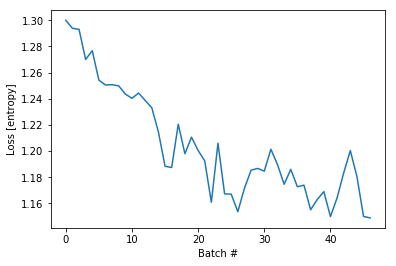

In [5]:
# Loss still pretty small. but Since this is the first time I shuffled, 
# the loss history looks really much more interesting.
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

print(minidata['x_train'].shape)
train_subset = np.random.choice(np.arange(0, minidata['x_train'].shape[0], 1),
                               10000, replace=False)
print('subset, ', len(train_subset))

# First make sure this random training subset covers all four classes.
print('train subset classes,', Counter(np.argmax(minidata['y_train'][train_subset, :], axis=1)))

%time y_pred_train = model(tf.convert_to_tensor(minidata['x_train'][train_subset], dtype=tf.float32))

# confusion... 
tf.confusion_matrix(
    np.argmax(minidata['y_train'][train_subset, :], axis=1),  # labels

    np.argmax(y_pred_train, axis=1), # predictions
    num_classes=4)



In [ ]:
# Wow that is so volatile. Here I brought down the class=3 weight again ever so slightly.
# And again now we flip back to class=1. 
#
# At this point I can only assume that the one 'respiration' feature I have is not
# good enough to help distinguish between class=1 and class=3 properly. 
# So have to add more of the data...

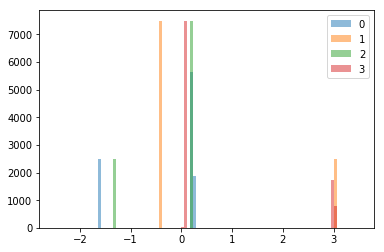

In [30]:
# Quick Look at how crisp the outputs are .
# And actually hmm wow that looks pretty nice and crisp.


bins = np.linspace(-2.5, 3.5, 100)
plt.hist(y_pred_train[:, 0], bins, alpha=0.5, label='0')
plt.hist(y_pred_train[:, 1], bins, alpha=0.5, label='1')
plt.hist(y_pred_train[:, 2], bins, alpha=0.5, label='2')
plt.hist(y_pred_train[:, 3], bins, alpha=0.5, label='3')
plt.legend(loc='upper right')
plt.show()
